In this notebook, we are running `tractor` with forced photometry. First, we run `tractor` on the i-band images, then we pass the modeled parameters such as position, shape, and Sersic index to initialize the `tractor` on the other bands. 

Ultimately, the inverse variance of the modeled flux parameter is saved. 

In [6]:
# import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from astropy.utils.data import download_file, clear_download_cache
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import wcs

import kuaizi
from kuaizi.tractor.utils import tractor_hsc_sep
from kuaizi.download import download_decals_cutout

import pickle
from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# print version
kuaizi.__version__

'0.1.dev108+g7212958'

In [8]:
# load catalog and images (ladybug sample)
obj_cat = Table.read('/home/diana/Research/ladybug_tractor/ladybug/ladybug-2021-03-03.fits')

# save all files into './output'
import os
#os.chdir('./output')
os.getcwd()

'/home/diana/Research/new_kuaizi_with_forced_photometry'

In [32]:


# changed to be a function rather than loop 
def forcedPhotometry(obj, ref_filt, channels, forced_channels):
    '''
    Performs forced photometry using the channel specified. 
    
    Parameters
    
    ``````````
    obj: `astropy.table.row.Row` object
        row pertaining to cutout image
    ref_filt: str
        channel used to initialize tractor (ie, 'i')
    channels: str
        all channels, including the reference filter (ie, 'grizy')
    forced_channels: str
        channels to perform forced photometry over (ie, 'grzy')

        
    Returns
    
    `````````
    model_dict: dict of tractor objects
    
    '''
    
    channels = channels
    forced_channels = forced_channels
    
    
    
    obj_name = obj['name'].rstrip('_y')
    obj_id = obj_name.lstrip('ladybug_')
    
    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    cutout = [
        fits.open(
            f'/home/diana/Research/ladybug_tractor/ladybug/1/{obj_id}/hsc/ladybug_{obj_id}_{filt}.fits'
        ) for filt in channels
    ]
    psf_list = [
        fits.open(
            f'/home/diana/Research/ladybug_tractor/ladybug/1/{obj_id}/hsc/ladybug_{obj_id}_{filt}_psf.fits'
        ) for filt in channels
    ]

    # reconstruct data
    from kuaizi.detection import Data
    from kuaizi.utils import padding_PSF 
    
    images = np.array([hdu[1].data for hdu in cutout])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    

    # list of channels to perform forced photometry
    forced_filters = list(forced_channels)
    # all channels
    filters = list(channels)
    
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    # `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy,
    # this includes all channels
    
    # start fitting in the i-band first, then pass the i-band parameters of target galaxy to other bands
    # reference filter
    ref_filt = ref_filt
    
    model_dict = {}

    model_dict[ref_filt] = tractor_hsc_sep(obj, ref_filt, channels, data,
                                           freeze_dict = {'pos': True, 'shape': False, 'sersicindex': False}, 
                                           brick_file='/home/diana/Research/research_downloads/survey-bricks.fits.gz',
                                           verbose=True)
    
    # forced photometry in rest of bands, using modified `tractor_hsc_sep`
    for filt in forced_channels: 
        model_dict[filt] = tractor_hsc_sep(obj, filt, channels, data, 
                                                  freeze_dict = {'pos': True, 'shape': True, 'sersicindex': True},
                                                  brick_file='/home/diana/Research/research_downloads/survey-bricks.fits.gz',
                )
        
    ### ^ this is where things go wrong! Please see 'rubberband/tractor/rubber_utils.py' (where `rubber_tractor_hsc_sep` is located) ###
        
    # save dictionaries into a pickle
    with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
        pickle.dump(model_dict, f)
        

    return model_dict
    #clear_output()
    #plt.close()

### `ladybug_158` i-band
    Detected 20 objects
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/150/tractor-1503p025.fits ./tractor-1503p025.fits
!!!The file "./tractor-1503p025.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 20
# Central object index in i-band: 0
 - Now you have 1 sources
Target source: SersicGalaxy at pixel (119.76, 118.23) with Flux: 6313.23 and EllipseE: re=3.45858, e1=-0.0798503, e2=-0.214561, Sersic index 1.000
Target source flux inverse variance: 0.11786963790655136
 - Now you have 10 sources
Target source: SersicGalaxy at pixel (119.76, 118.23) with Flux: 7147.22 and EllipseE: re=3.52705, e1=-0.0606007, e2=-0.220915, Sersic index 0.961


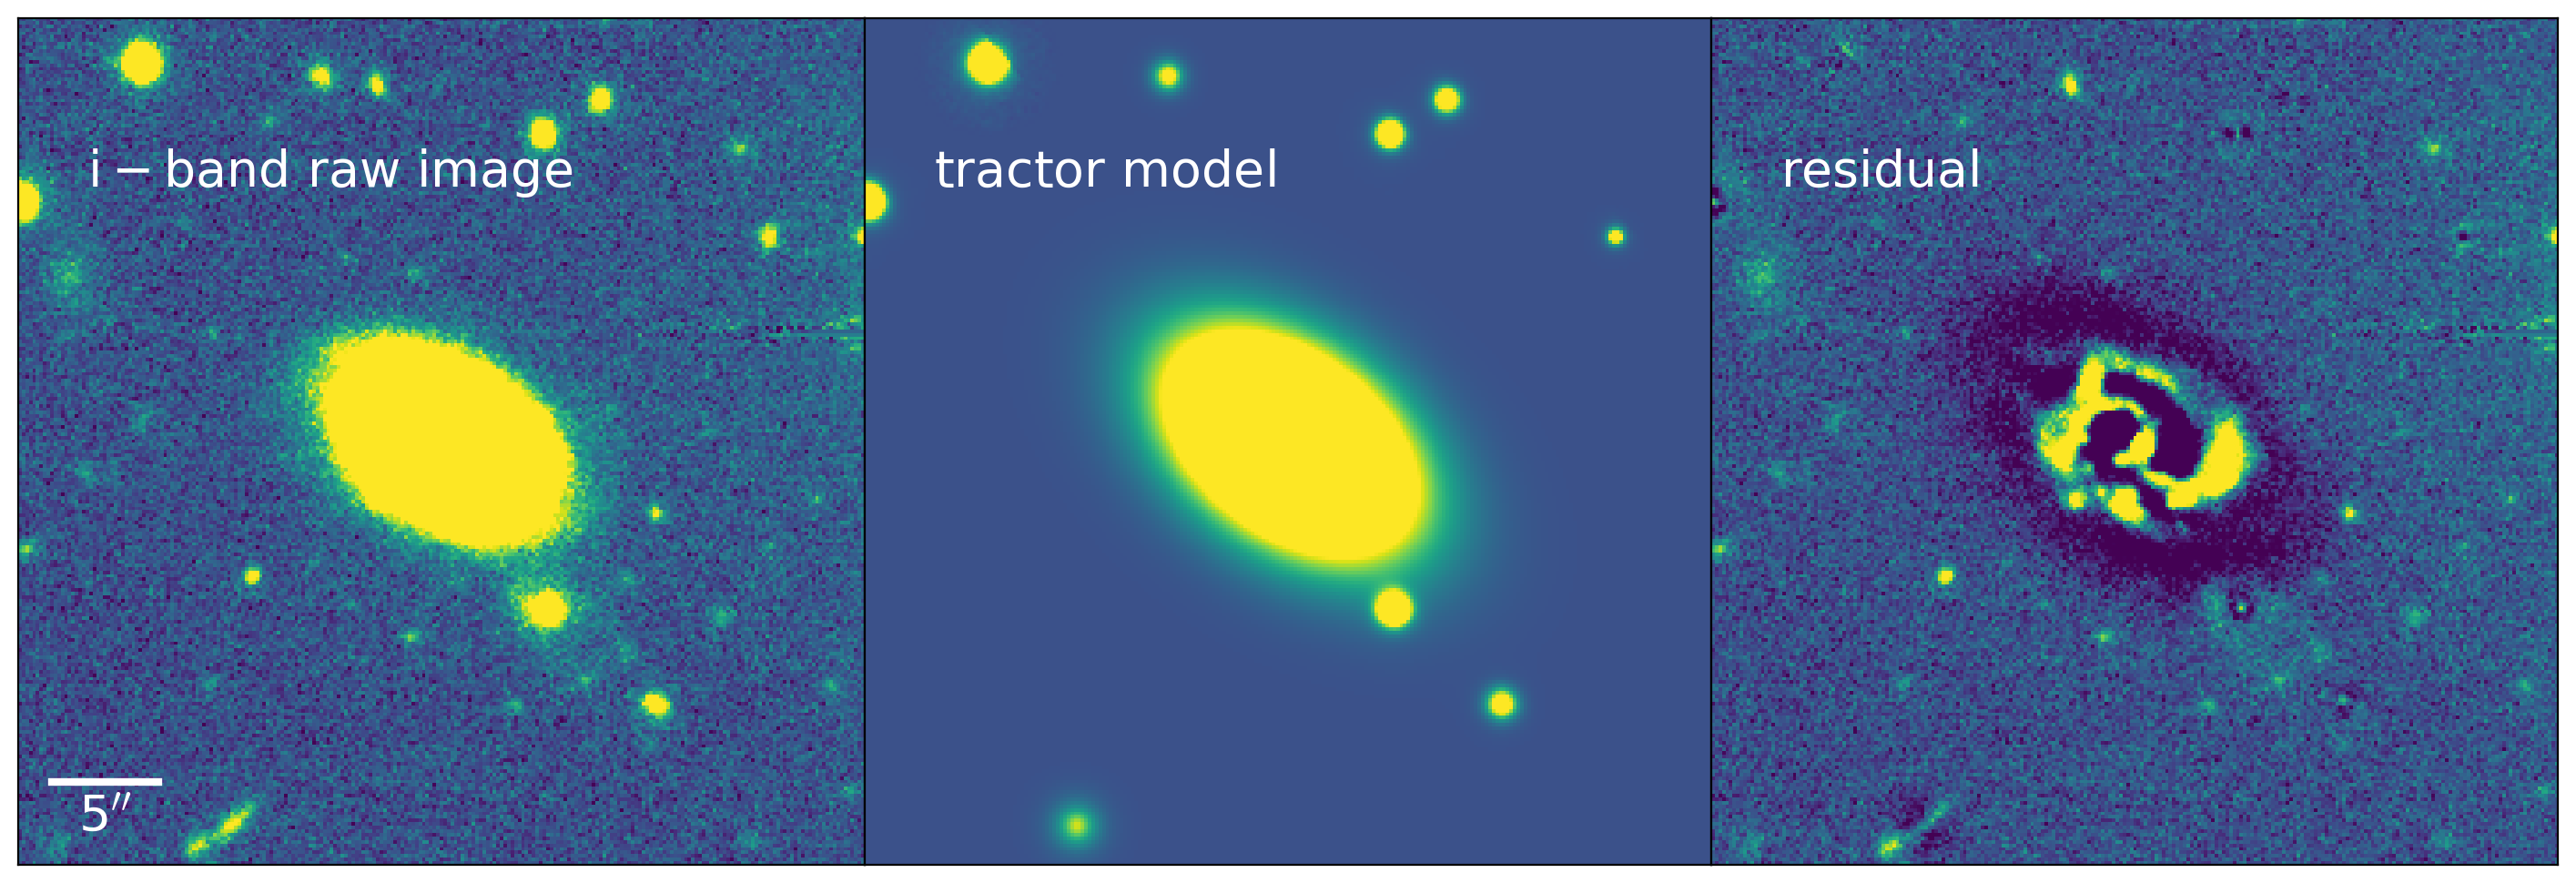

   The chi-square is 5944.3096
Target source flux inverse variance: 0.11998504400253296
 - Now you have 19 sources
Target source: SersicGalaxy at pixel (119.76, 118.23) with Flux: 7079.64 and EllipseE: re=3.48035, e1=-0.063815, e2=-0.218147, Sersic index 0.938


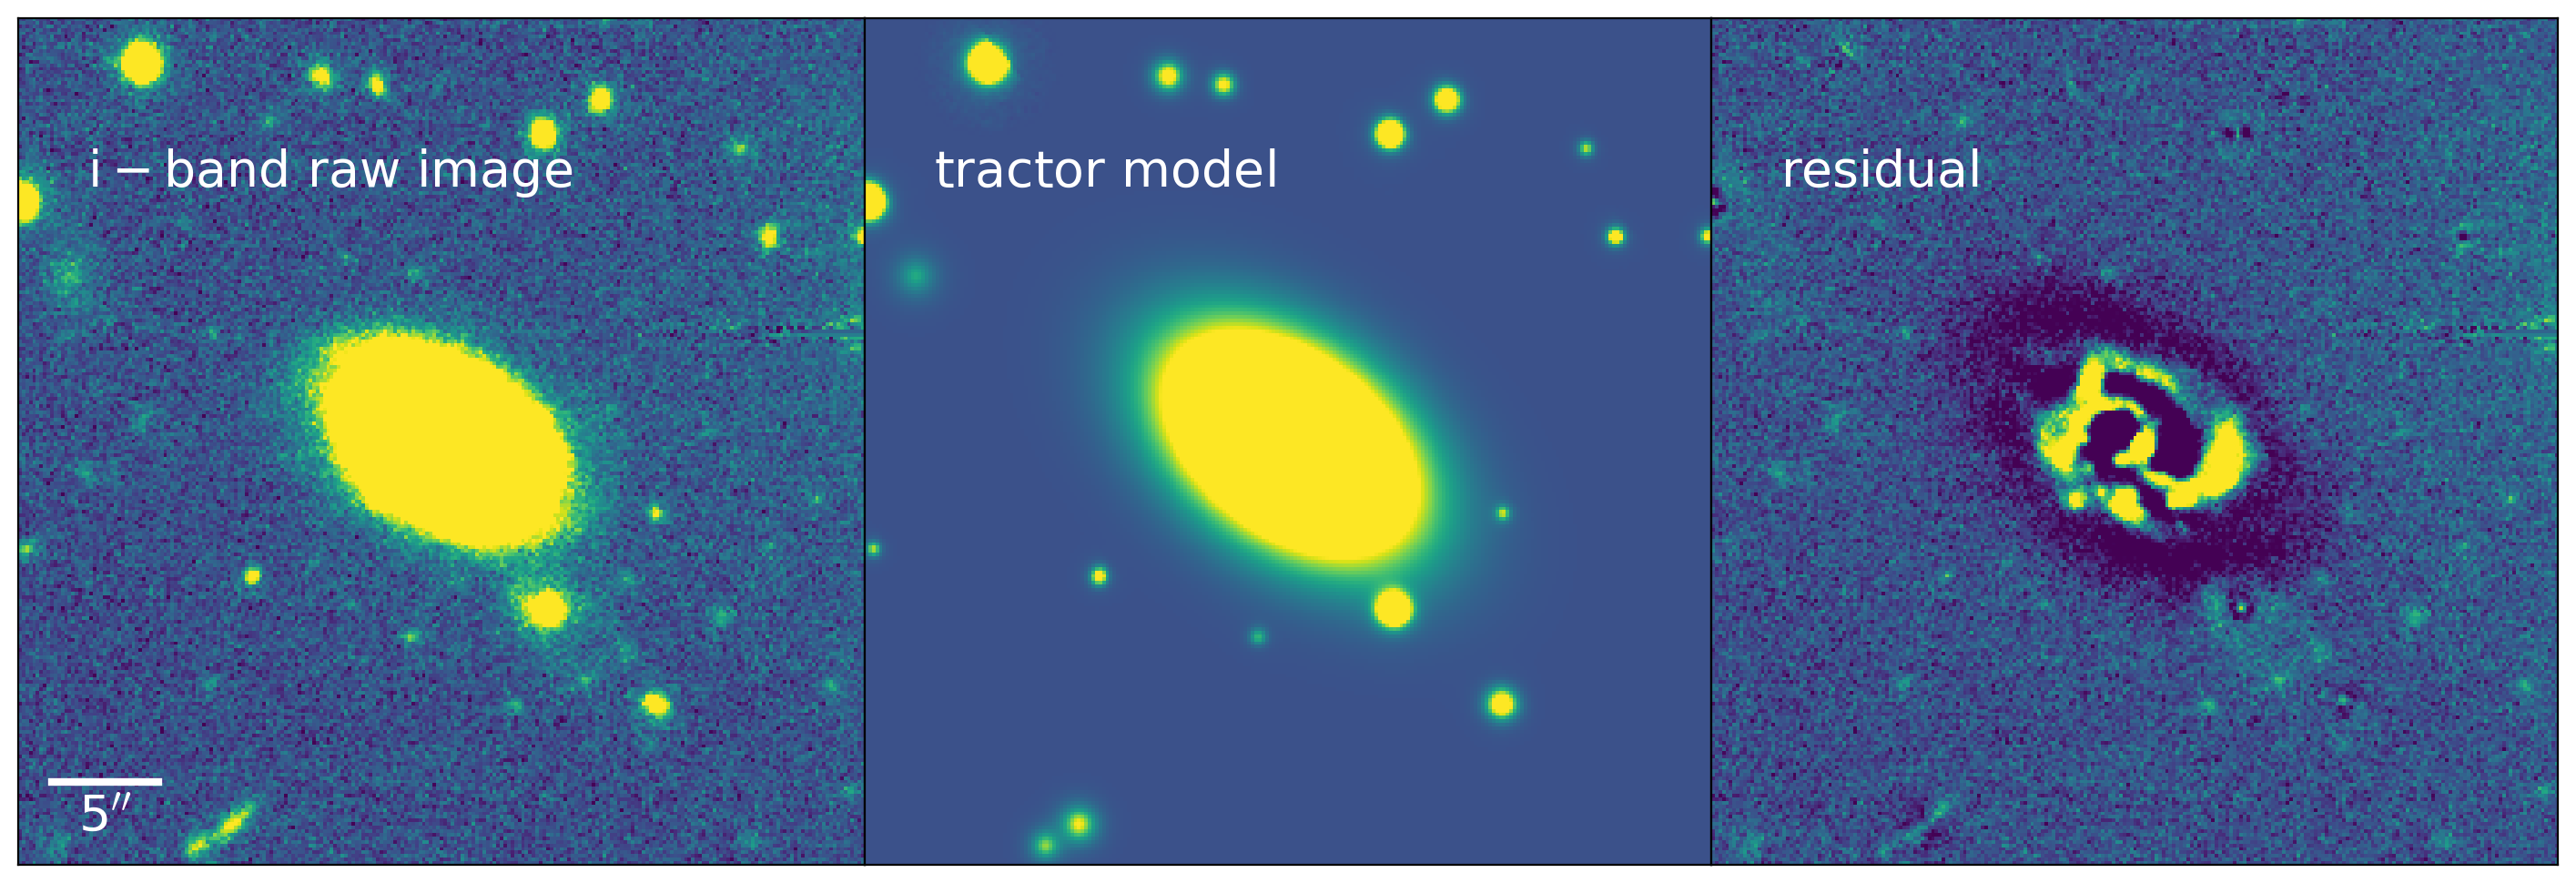

   The chi-square is 5884.6875
Target source flux inverse variance: 0.12006038427352905
### `ladybug_158` g-band
    Detected 11 objects
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/150/tractor-1503p025.fits ./tractor-1503p025.fits
!!!The file "./tractor-1503p025.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 11
# Central object index in g-band: 0
 - Now you have 1 sources
Target source: SersicGalaxy at pixel (119.70, 118.37) with Flux: 3115.75 and EllipseE: re=3.45858, e1=-0.0798503, e2=-0.214561, Sersic index 1.000
Target source flux inverse variance: 0.22165347635746002
 - Now you have 6 sources
Target source: SersicGalaxy at pixel (119.70, 118.37) with Flux: 3294.88 and EllipseE: re=3.45858, e1=-0.0798503, e2=-0.214561, Sersic index 1.000
   The chi-square is 3072.4644
Target source flux inverse variance: 0.22165347635746002
 - Now you have 11 sources
Target source: SersicGalaxy at pixel (119.70, 118.37) with Flux: 3

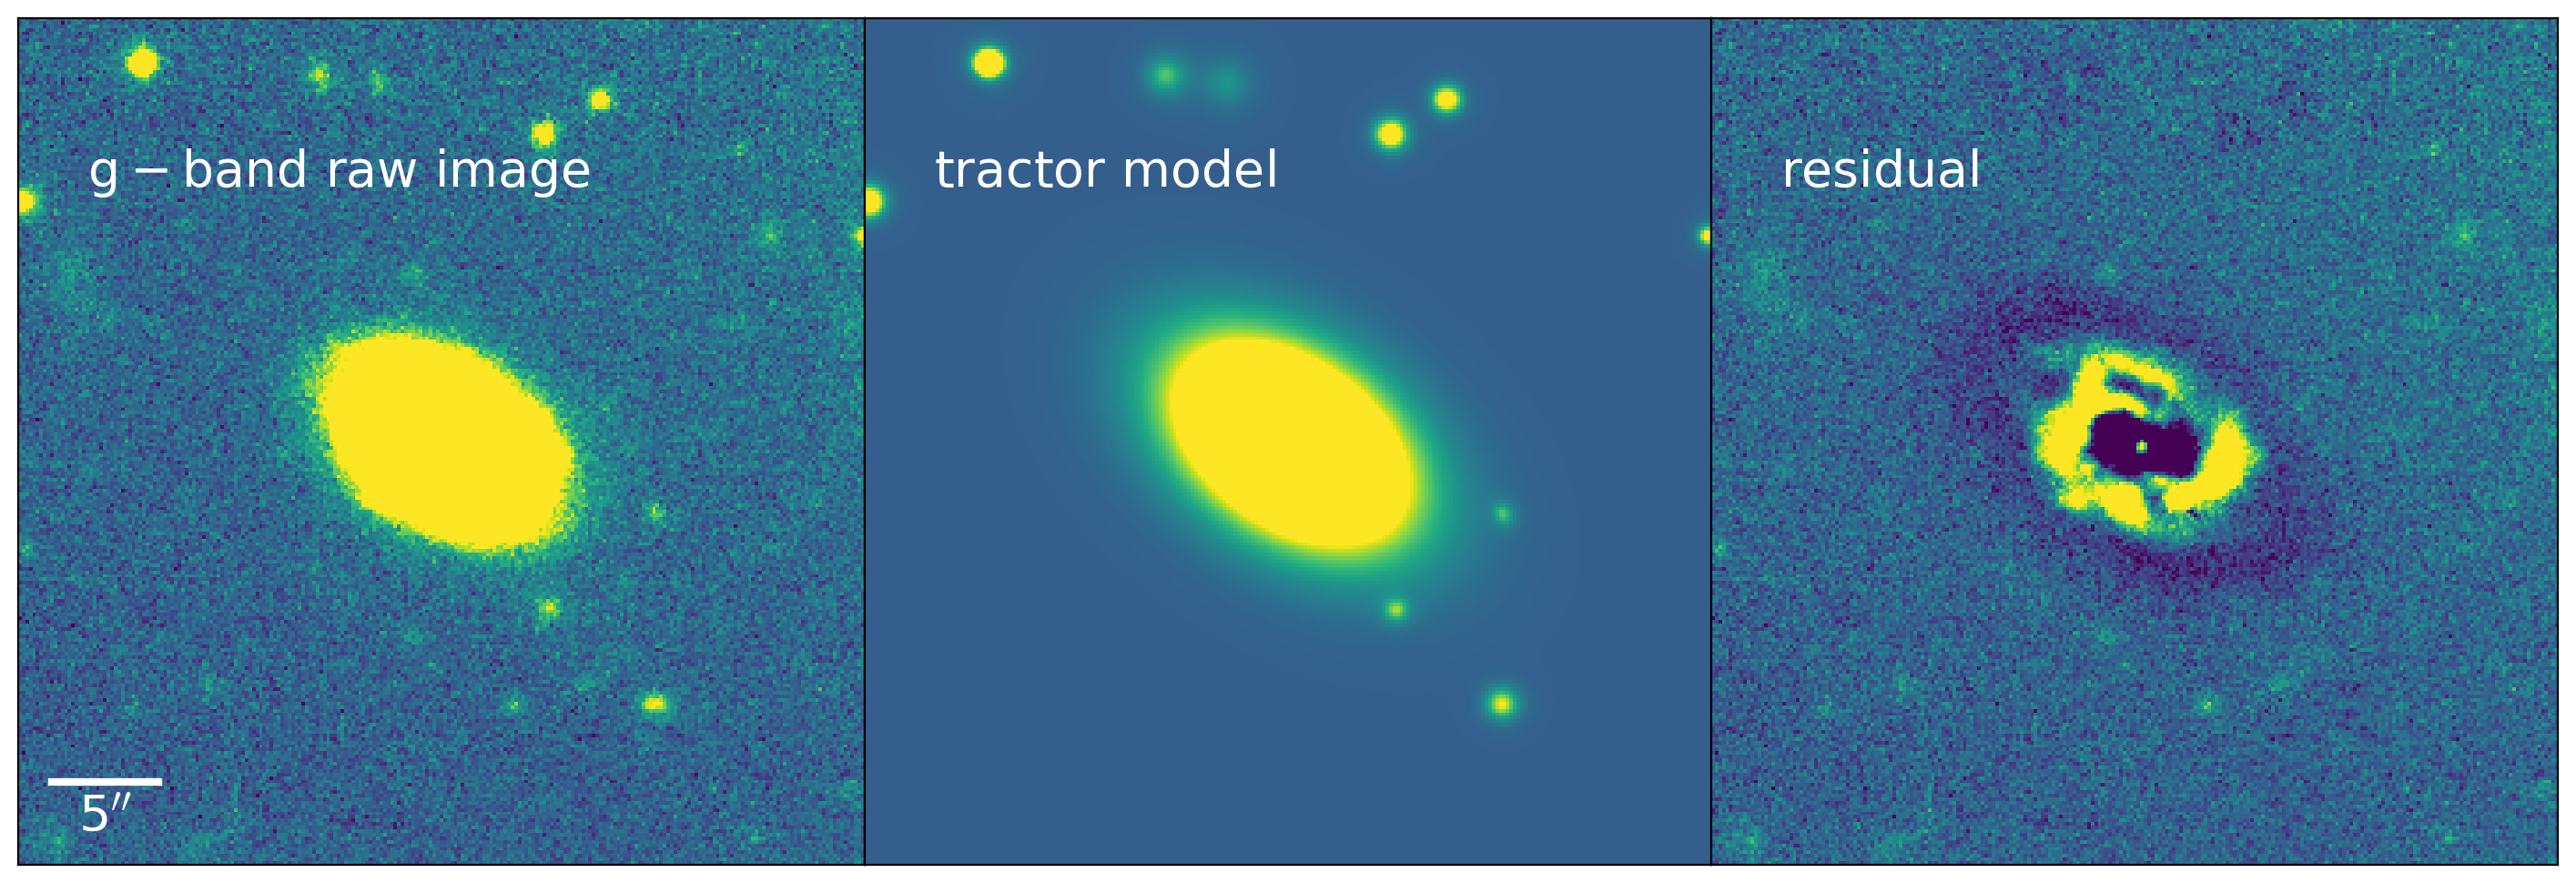

   The chi-square is 3112.3254
Target source flux inverse variance: 0.22165347635746002
### `ladybug_158` r-band
    Detected 14 objects
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/150/tractor-1503p025.fits ./tractor-1503p025.fits
!!!The file "./tractor-1503p025.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 14
# Central object index in r-band: 0
 - Now you have 1 sources
Target source: SersicGalaxy at pixel (119.83, 118.40) with Flux: 4794.93 and EllipseE: re=3.45858, e1=-0.0798503, e2=-0.214561, Sersic index 1.000
Target source flux inverse variance: 0.15649783611297607
 - Now you have 7 sources
Target source: SersicGalaxy at pixel (119.83, 118.40) with Flux: 5223.05 and EllipseE: re=3.45858, e1=-0.0798503, e2=-0.214561, Sersic index 1.000
   The chi-square is 7315.2266
Target source flux inverse variance: 0.15649783611297607
 - Now you have 13 sources
Target source: SersicGalaxy at pixel (119.83, 118.40) with Flux: 5

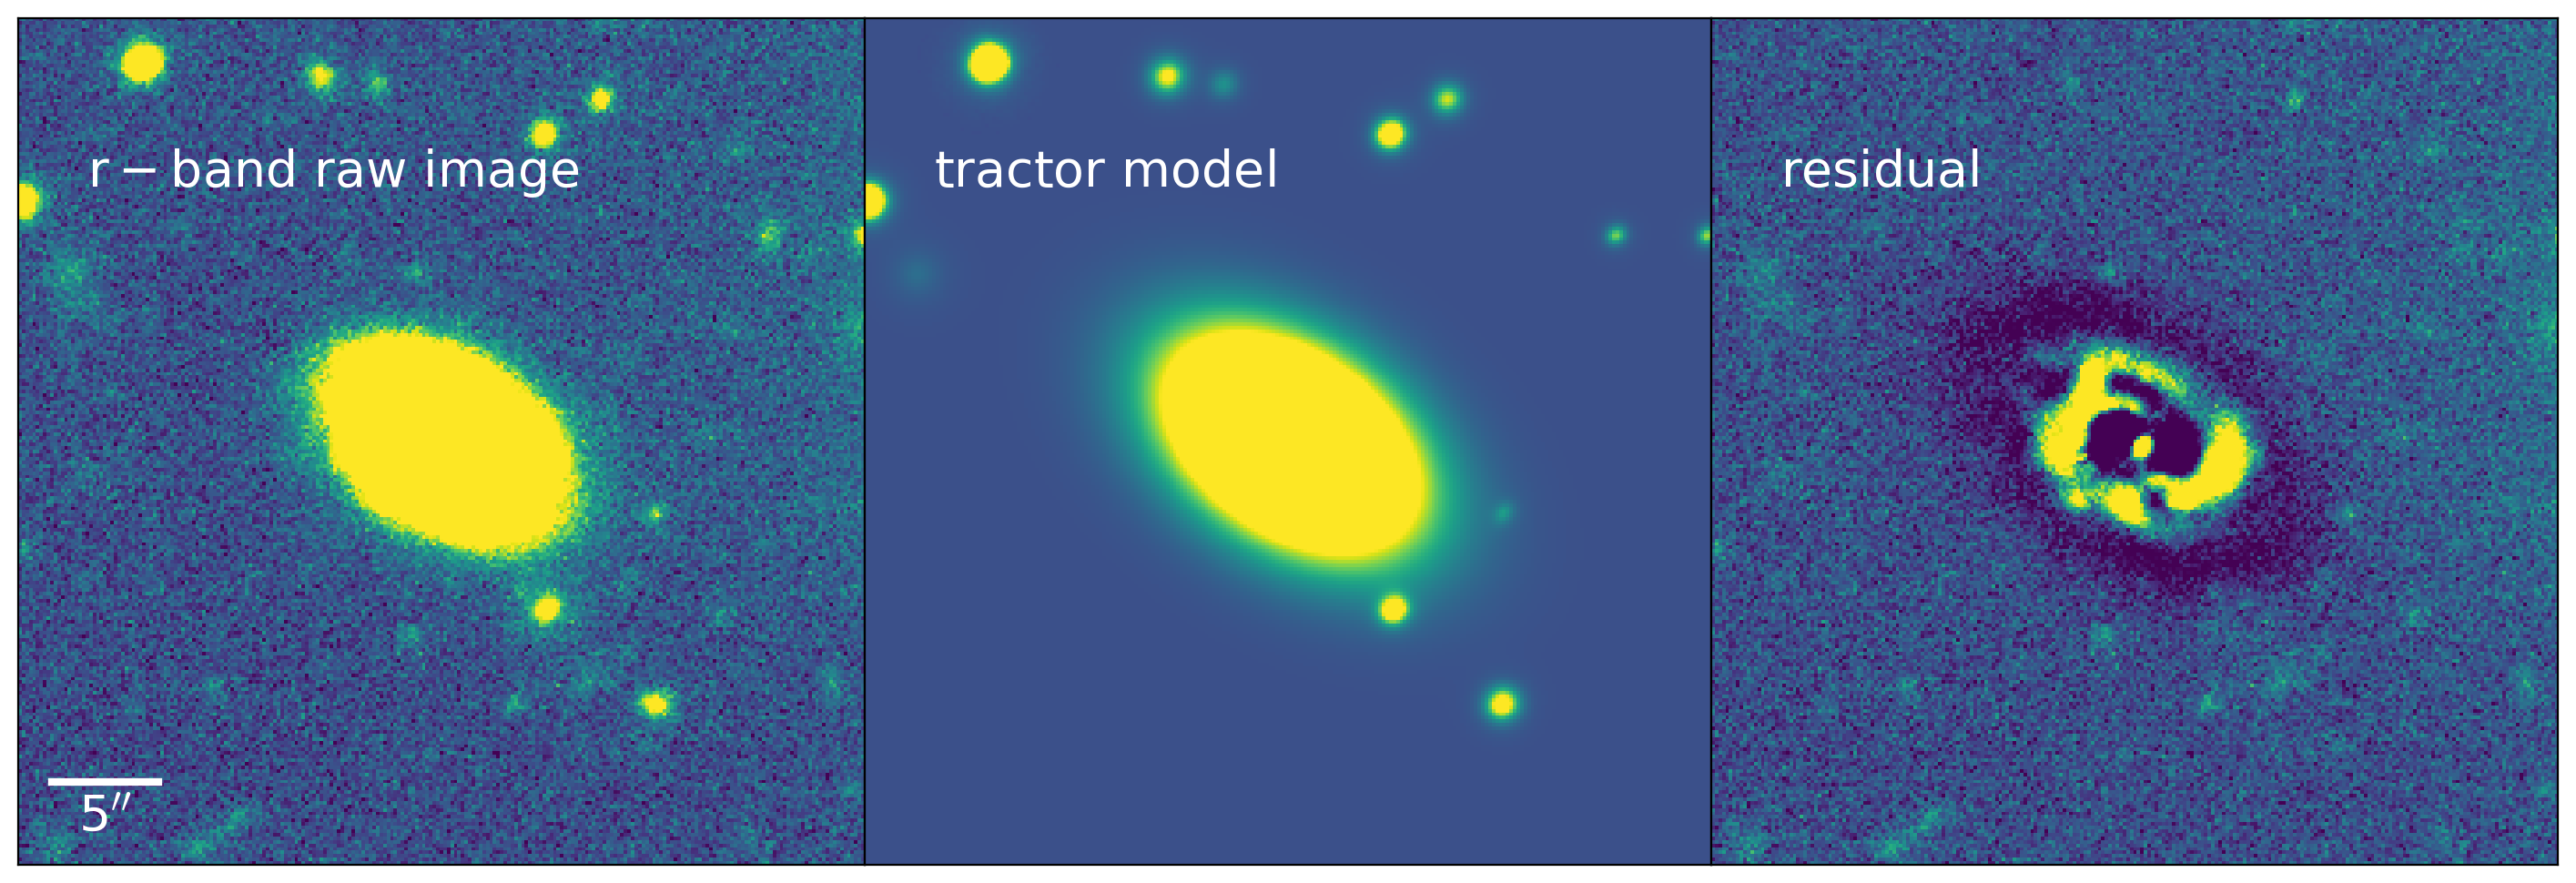

   The chi-square is 7281.7817
Target source flux inverse variance: 0.15649783611297607
### `ladybug_158` z-band
    Detected 15 objects
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/150/tractor-1503p025.fits ./tractor-1503p025.fits
!!!The file "./tractor-1503p025.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 15
# Central object index in z-band: 0
 - Now you have 1 sources
Target source: SersicGalaxy at pixel (119.88, 118.28) with Flux: 7012.45 and EllipseE: re=3.45858, e1=-0.0798503, e2=-0.214561, Sersic index 1.000
Target source flux inverse variance: 0.03445388749241829
 - Now you have 8 sources
Target source: SersicGalaxy at pixel (119.88, 118.28) with Flux: 8135.47 and EllipseE: re=3.45858, e1=-0.0798503, e2=-0.214561, Sersic index 1.000
   The chi-square is 10366.454
Target source flux inverse variance: 0.03445388749241829
 - Now you have 15 sources
Target source: SersicGalaxy at pixel (119.88, 118.28) with Flux: 8

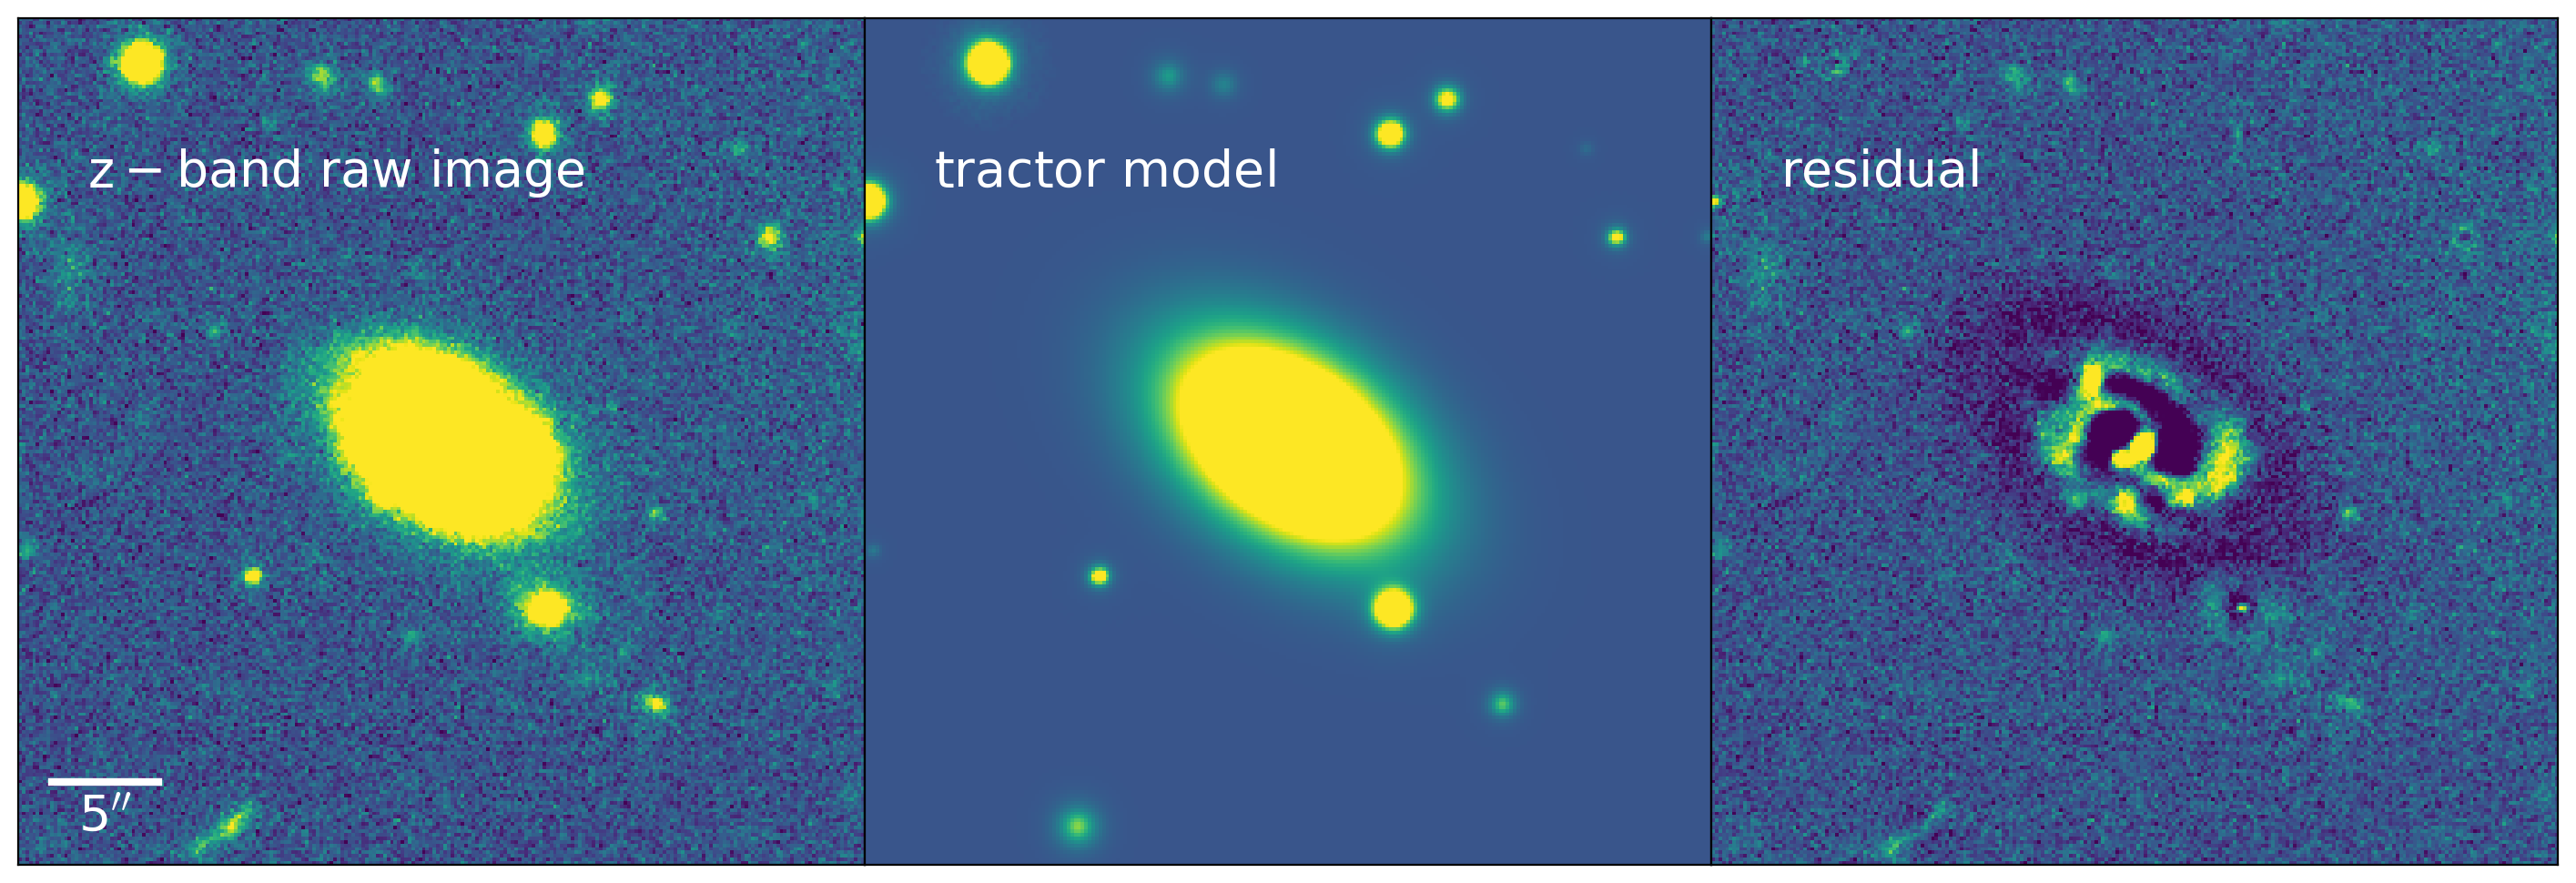

   The chi-square is 10303.785
Target source flux inverse variance: 0.03445388749241829
### `ladybug_158` y-band
    Detected 11 objects
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/150/tractor-1503p025.fits ./tractor-1503p025.fits
!!!The file "./tractor-1503p025.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 11
# Central object index in y-band: 0
 - Now you have 1 sources
Target source: SersicGalaxy at pixel (119.97, 118.23) with Flux: 7572.27 and EllipseE: re=3.45858, e1=-0.0798503, e2=-0.214561, Sersic index 1.000
Target source flux inverse variance: 0.008254749700427055
 - Now you have 6 sources
Target source: SersicGalaxy at pixel (119.97, 118.23) with Flux: 9383.79 and EllipseE: re=3.45858, e1=-0.0798503, e2=-0.214561, Sersic index 1.000
   The chi-square is 57524.234
Target source flux inverse variance: 0.008254749700427055
 - Now you have 11 sources
Target source: SersicGalaxy at pixel (119.97, 118.23) with Flux:

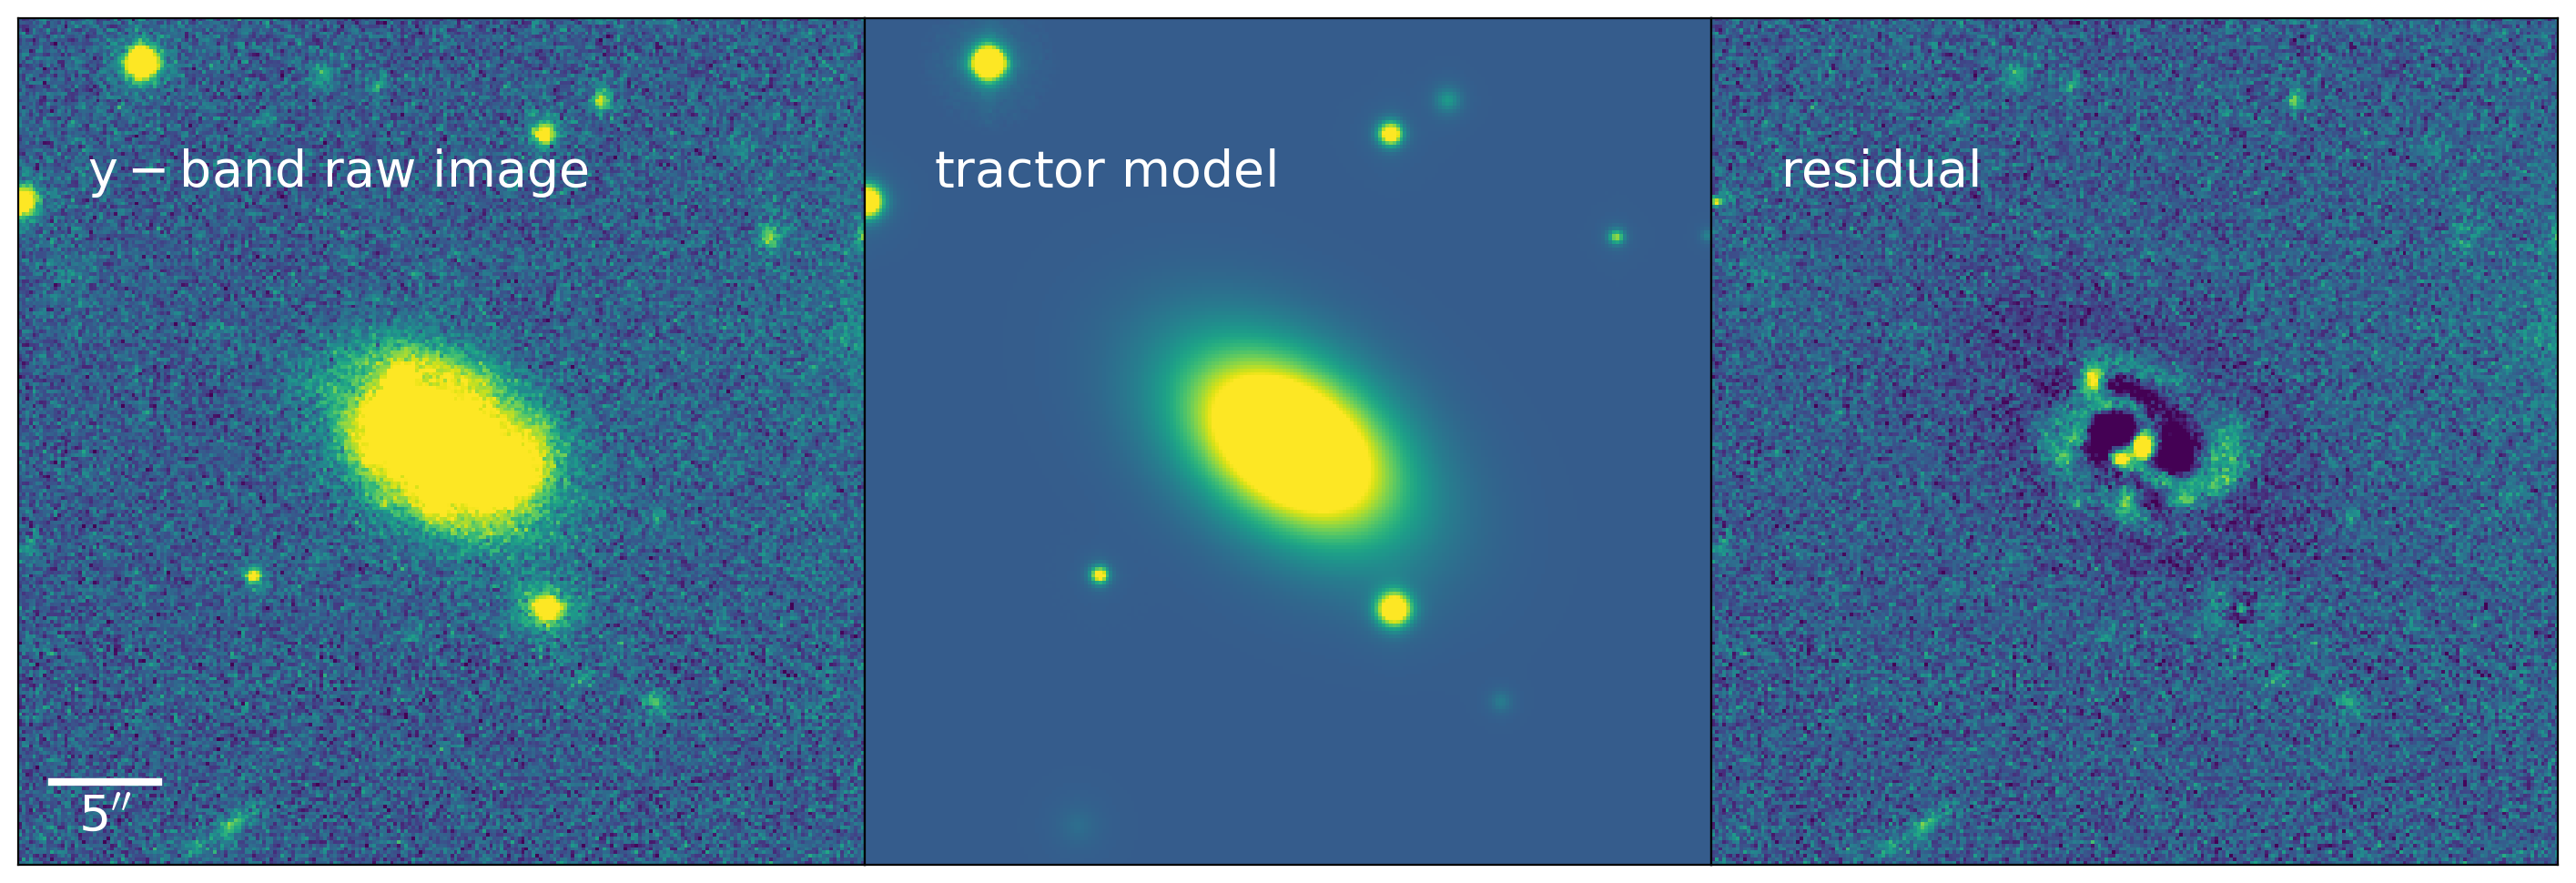

   The chi-square is 57484.688
Target source flux inverse variance: 0.008254749700427055


In [33]:
model_dict = forcedPhotometry(obj_cat[2], ref_filt = 'i', channels = 'grizy', forced_channels = 'grzy')

### The inverse variance of the flux is saved as the last value of the dictionary for each filter. 

In [36]:
model_dict['i']

(Tractor[7077.322057287097, 3.4788852345285557, -0.06374693550346916, -0.2181425357721091, 0.9374771788697567, 34.417129964833585, 225.52231516967814, 441.67323943964453, 148.9778846085699, 71.60407786065441, 106.7271302871736, 0.31566571816073746, 0.41013138604272553, 186.54396411780527, 159.4020173510118, 0.26940980591820674, 147.88449517474774, 205.5682041572018, 68.50638899582242, 0.21582711581700736, 163.8964484742672, 215.26604690119592, 37.50836768938174, 0.267933349330376, 179.37540193698106, 44.857824524328095, 37.87834391918794, 0.37538362877213727, 59.97601649430113, 10.920299534503965, 31.880810481524843, 0.6024100177916402, 85.2043811984208, 221.94441278203726, 27.198472239100436, 0.39591385684899416, 211.5210552110697, 176.6715094074316, 13.643914449540727, 50.52526294093277, 4.90854745383546, 16.560500976454016, 0.45262492918626435, 100.81965708708505, 219.52722253811874, 14.964347355362076, 0.24670285161341016, 65.68076372260674, 80.88338478966611, 11.563020787555256, 0